Ir al enlace https://colab.research.google.com en un Navegador y haga Click en Nuevo Cuaderno

Seleccione el coprocesador GPU en Entorno de ejecución/cambiar tipo de entorno de ejecución

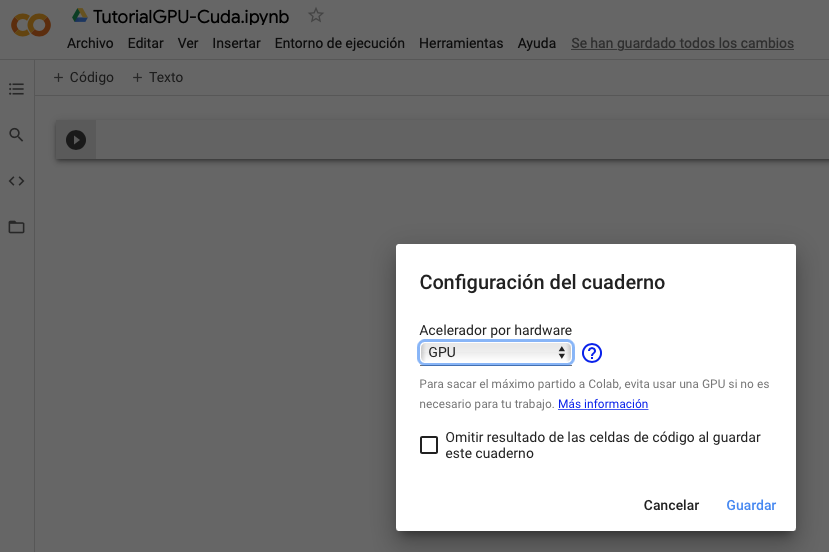

Comprobar la CPU

In [ ]:
!lscpu

Comprobar la memoria disponible

In [ ]:
!free -kh

In [ ]:
!cat /proc/meminfo

Ver directorio actual

In [ ]:
!pwd

Listar el contenido

In [ ]:
!ls -la

Ver el contenido del directorio /usr/local  donde está instalado CUDA

In [ ]:
!ls -la /usr/local

In [ ]:
!ls -la /usr/local/cuda-11.1/bin

In [ ]:
!ls -la /usr/local/cuda-11.1/samples


Compidador y utilidades CUDA

In [ ]:
!nvcc --version

In [ ]:
!nvidia-smi

listar ejemplos

In [18]:
!ls -la /usr/local/cuda/samples/

total 108
drwxr-xr-x 11 root root  4096 Sep 30 17:02 .
drwxr-xr-x  1 root root  4096 Sep 30 17:02 ..
drwxr-xr-x 63 root root  4096 Sep 30 17:02 0_Simple
drwxr-xr-x  8 root root  4096 Sep 30 17:02 1_Utilities
drwxr-xr-x 14 root root  4096 Sep 30 17:02 2_Graphics
drwxr-xr-x 24 root root  4096 Sep 30 17:02 3_Imaging
drwxr-xr-x 10 root root  4096 Sep 30 17:02 4_Finance
drwxr-xr-x 10 root root  4096 Sep 30 17:02 5_Simulations
drwxr-xr-x 36 root root  4096 Sep 30 17:02 6_Advanced
drwxr-xr-x 37 root root  4096 Sep 30 17:02 7_CUDALibraries
drwxr-xr-x  6 root root  4096 Sep 30 17:02 common
-rw-r--r--  1 root root 60537 Oct 13  2020 EULA.txt
-rw-r--r--  1 root root  2606 Oct 13  2020 Makefile


Compilar ejemplo

In [ ]:
%cd /usr/local/cuda/samples/1_Utilities/deviceQuery/
%ls

In [ ]:
!make

In [ ]:
!ls -la

Correr el ejecutable

In [ ]:
!./deviceQuery

Compilar en cuda

In [ ]:
%cd /content/

In [ ]:
%ls

hacer un directorio de trabajo

In [25]:
!mkdir workcuda

In [ ]:
cd workcuda/


In [ ]:
!pwd

Crear un fichero y escribir el contenindo

In [ ]:
%%writefile suma1d.cu

#include <stdio.h>
#include <stdlib.h>

__global__ void add(int *a, int *b, int *c) {
*c = *a + *b;
}

int main() {
int a, b, c;

// host copies of variables a, b & c
int *d_a, *d_b, *d_c;
// device copies of variables a, b & c
int size = sizeof(int);

// Allocate space for device copies of a, b, c
cudaMalloc((void **)&d_a, size);
cudaMalloc((void **)&d_b, size);
cudaMalloc((void **)&d_c, size);

// Setup input values  
c = 0;
a = 3;
b = 5;

// Copy inputs to device
cudaMemcpy(d_a, &a, size, cudaMemcpyHostToDevice);
cudaMemcpy(d_b, &b, size, cudaMemcpyHostToDevice);

// Launch add() kernel on GPU
add<<<1,1>>>(d_a, d_b, d_c);

// Copy result back to host
cudaError err = cudaMemcpy(&c, d_c, size, cudaMemcpyDeviceToHost);
  if(err!=cudaSuccess) {
      printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
  }
printf("result is %d\n",c);

// Cleanup
cudaFree(d_a);
cudaFree(d_b);
cudaFree(d_c);

return 0;
}

In [ ]:
ls -la

Compilar

In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true suma1d.cu -o suma1d -lcudadevrt

In [ ]:
ls -la

Ejecutar

In [ ]:
!./suma1d

Comprobar el perfil de ejecución

In [ ]:
!nvprof ./suma1d

# **PARALELIZAR**

# Lanzando N Bloques de 1 Thread

In [ ]:
%%writefile suma2dvector.cu

#include <stdio.h>
#include <stdlib.h>

__global__ void add(int *a, int *b, int *c) {
//*c = *a + *b;
c[blockIdx.x] = a[blockIdx.x] + b[blockIdx.x]; 
}

#define N 512

int main(void) {
int *a, *b, *c;        // host copies of variables a, b & c
int *d_a, *d_b, *d_c;  // device copies of variables a, b & c
int size = N * sizeof(int);

// Allocate space for host copies of a, b, c   Setup input values  
a =  (int *) malloc(size); 
b =  (int *) malloc(size); 
c =  (int *) malloc(size); 


// Setup input values  

for( int i = 0; i < N; i++ )
	{
		a[i] = i;
    b[i] = N-i;
		c[i] = 0;
	}


// Allocate space for device copies of a, b, c
cudaMalloc((void **)&d_a, size);
cudaMalloc((void **)&d_b, size);
cudaMalloc((void **)&d_c, size);


// Copy inputs to device
cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

// Launch add() kernel on GPU  Se lanzan N bloques de 1 Thread.
add<<<N,1>>>(d_a, d_b, d_c);

// Copy result back to host
cudaError err = cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
  if(err!=cudaSuccess) {
      printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
  }
printf(" valor a[0] es %d\n",a[0]);
printf(" valor b[0] es %d\n",b[0]);
printf("resultado c[0] es %d\n",c[0]);
printf(" valor a[2] es %d\n",a[2]);
printf(" valor b[2] es %d\n",b[2]);
printf("resultado c[2] es %d\n",c[2]);

// Cleanup

free(a); free(b);free(c); 

cudaFree(d_a);
cudaFree(d_b);
cudaFree(d_c);

return 0;
}

Compilar:

In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true suma2dvector.cu -o suma2dvector -lcudadevrt

Ver si se ha generado el ejecutable

In [ ]:
%ls

Ejecutar

In [ ]:
!./suma2dvector

Comprobar el perfil de ejecución y compare el resultado con el caso anterior.

In [61]:
!nvprof ./suma2dvector

==704== NVPROF is profiling process 704, command: ./suma2dvector
==704== Warning: Auto boost enabled on device 0. Profiling results may be inconsistent.
 valor a[0] es 0
 valor b[0] es 512
resultado c[0] es 512
 valor a[2] es 2
 valor b[2] es 510
resultado c[2] es 512
==704== Profiling application: ./suma2dvector
==704== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   41.90%  5.2160us         1  5.2160us  5.2160us  5.2160us  add(int*, int*, int*)
                   36.76%  4.5760us         2  2.2880us  2.0160us  2.5600us  [CUDA memcpy HtoD]
                   21.34%  2.6560us         1  2.6560us  2.6560us  2.6560us  [CUDA memcpy DtoH]
      API calls:   99.45%  196.59ms         3  65.529ms  2.2570us  196.58ms  cudaMalloc
                    0.30%  583.18us         1  583.18us  583.18us  583.18us  cuDeviceTotalMem
                    0.12%  238.69us       101  2.3630us     156ns  105.95us  cuDeviceGetAttribute
      

# Lanzando 1 Bloque de N Threads

In [ ]:
%%writefile suma2dvectorNthreads.cu

#include <stdio.h>
#include <stdlib.h>

__global__ void add(int *a, int *b, int *c) {
c[threadIdx.x] = a[threadIdx.x] + b[threadIdx.x]; 
}

#define N 1028

int main(void) {
int *a, *b, *c;        // host copies of variables a, b & c
int *d_a, *d_b, *d_c;  // device copies of variables a, b & c
int size = N * sizeof(int);

// Allocate space for host copies of a, b, c   Setup input values  
a =  (int *) malloc(size); 
b =  (int *) malloc(size); 
c =  (int *) malloc(size); 


// Setup input values  

for( int i = 0; i < N; i++ )
	{
		a[i] = i;
    b[i] = N-i;
		c[i] = 0;
	}


// Allocate space for device copies of a, b, c
cudaMalloc((void **)&d_a, size);
cudaMalloc((void **)&d_b, size);
cudaMalloc((void **)&d_c, size);


// Copy inputs to device
cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

// Launch add() kernel on GPU  Se lanzan 1 bloques de N Threads.
add<<<1,N>>>(d_a, d_b, d_c);

// Copy result back to host
cudaError err = cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
  if(err!=cudaSuccess) {
      printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
  }
printf(" valor a[10] es %d\n",a[10]);
printf(" valor b[10] es %d\n",b[10]);
printf("resultado c[10] es %d\n",c[10]);
printf(" valor a[0] es %d\n",a[0]);
printf(" valor b[0] es %d\n",b[0]);
printf("resultado c[0] es %d\n",c[0]);

// Cleanup

free(a); free(b);free(c); 

cudaFree(d_a);
cudaFree(d_b);
cudaFree(d_c);

return 0;
}

In [ ]:
ls

Compilar:


In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true suma2dvectorNthreads.cu -o suma2dvectorNthreads -lcudadevrt

ver si se ha generado el ejecutable y lanzarlo

In [ ]:
%ls

In [ ]:
!./suma2dvectorNthreads

Comprobar el perfil de ejecución y compare el resultado con los casos anteriores

In [ ]:
!nvprof ./suma2dvectorNThreads

# Preguntas

* Pruebe a lanzar diferente número de Threads ( con un solo 1 bloque)
¿Cual son los valores máximos y mínimos de número de theads por bloque en esta GPU?

Pruebe a lanzar diferente número de bloques ( con un solo thread) ¿Cual son los valores máximos y mínimos de número de bloques en esta GPU?

#Lanzando NUMBLOQ Bloques de NUMTHREADS Threads

In [ ]:
%%writefile suma2dvectorNBloqxNthreads.cu

#include <stdio.h>
#include <stdlib.h>

__global__ void add(int *a, int *b, int *c) {
int index = threadIdx.x + blockIdx.x * blockDim.x;
 c[index] = a[index] + b[index]; 
}

#define N (1024*1024)
#define THREADS_PER_BLOCK 512 

int main(void) {
int *a, *b, *c;        // host copies of variables a, b & c
int *d_a, *d_b, *d_c;  // device copies of variables a, b & c
int size = N*sizeof(int);

// Allocate space for host copies of a, b, c   Setup input values  
a =  (int *) malloc(size); 
b =  (int *) malloc(size); 
c =  (int *) malloc(size); 


// Setup input values  

for( int i = 0; i < N; i++ )
	{
		a[i] = i;
    b[i] = N-i;
		c[i] = 0;
	}


// Allocate space for device copies of a, b, c
cudaMalloc((void **)&d_a, size);
cudaMalloc((void **)&d_b, size);
cudaMalloc((void **)&d_c, size);


// Copy inputs to device
cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

// Launch add() kernel on GPU  Se lanzan NuBloq=N/THREADS_PER_BLOCK bloques de 
// THREADS_PER_BLOCK Threads.
add<<<N/THREADS_PER_BLOCK,THREADS_PER_BLOCK>>>(d_a, d_b, d_c);

// Copy result back to host
cudaError err = cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
  if(err!=cudaSuccess) {
      printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
  }
printf(" valor a[10] es %d\n",a[10]);
printf(" valor b[10] es %d\n",b[10]);
printf("resultado c[10] es %d\n",c[10]);
printf(" valor a[0] es %d\n",a[0]);
printf(" valor b[0] es %d\n",b[0]);
printf("resultado c[0] es %d\n",c[0]);

// Cleanup

free(a); free(b);free(c); 

cudaFree(d_a);
cudaFree(d_b);
cudaFree(d_c);

return 0;
}

In [ ]:
%ls

In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true suma2dvectorNBloqxNthreads.cu -o suma2dvectorNBloqxNthreads -lcudadevrt

In [ ]:
%ls

Ejecutar:

In [ ]:
!./suma2dvectorNBloqxNthreads

Comprobar el perfil de ejecución y compare el resultado con el caso anterior.

In [ ]:
!nvprof ./suma2dvectorNBloqxNthreads

Pregunta ¿Qué sucede si incrementa o disminuye el valor de N?

#EJERCICIO : realice el mismo procedimiento para la ejecución de Stencil1D

Compile el siguiente código, explique su funcionamiento y compruebe si la salida es correcta. En caso de que sea necesario realice las modificaciones oportunas.

In [ ]:
%%writefile stenciltest.cu

#include <stdio.h>

#define RADIUS        3
#define BLOCK_SIZE    256
#define NUM_ELEMENTS  (4096*2)

// CUDA API error checking macro
#define cudaCheck(error) \
  if (error != cudaSuccess) { \
    printf("Fatal error: %s at %s:%d\n", \
      cudaGetErrorString(error), \
      __FILE__, __LINE__); \
    exit(1); \
  }

__global__ void stencil_1d(int *in, int *out) 
{
    __shared__ int temp[BLOCK_SIZE + 2 * RADIUS];
    int gindex = threadIdx.x + (blockIdx.x * blockDim.x) + RADIUS;
    int lindex = threadIdx.x + RADIUS;

    // Read input elements into shared memory
    temp[lindex] = in[gindex];
    if (threadIdx.x < RADIUS) 
    {
        temp[lindex - RADIUS] = in[gindex - RADIUS];
        temp[lindex + BLOCK_SIZE] = in[gindex + BLOCK_SIZE];
    }

    // Make sure all threads get to this point before proceeding!
    //__syncthreads();

    // Apply the stencil
    int result = 0;
    for (int offset = -RADIUS ; offset <= RADIUS ; offset++)
        result += temp[lindex + offset];

    // Store the result
    out[gindex-RADIUS] = result;
}

int main()
{
  unsigned int i;
  int h_in[NUM_ELEMENTS + 2 * RADIUS], h_out[NUM_ELEMENTS];
  int *d_in, *d_out;

  // Initialize host data
  for( i = 0; i < (NUM_ELEMENTS + 2*RADIUS); ++i )
    h_in[i] = 1; // With a value of 1 and RADIUS of 3, all output values should be 7

  // Allocate space on the device
  cudaCheck( cudaMalloc( &d_in, (NUM_ELEMENTS + 2*RADIUS) * sizeof(int)) );
  cudaCheck( cudaMalloc( &d_out, NUM_ELEMENTS * sizeof(int)) );

  // Copy input data to device
  cudaCheck( cudaMemcpy( d_in, h_in, (NUM_ELEMENTS + 2*RADIUS) * sizeof(int), cudaMemcpyHostToDevice) );

  stencil_1d<<< (NUM_ELEMENTS + BLOCK_SIZE - 1)/BLOCK_SIZE, BLOCK_SIZE >>> (d_in, d_out);

  cudaCheck( cudaMemcpy( h_out, d_out, NUM_ELEMENTS * sizeof(int), cudaMemcpyDeviceToHost) );

  // Verify every out value is 7
  for( i = 0; i < NUM_ELEMENTS; ++i )
    if (h_out[i] != 7)
    {
      printf("Element h_out[%d] == %d != 7\n", i, h_out[i]);
      break;
    }

  if (i == NUM_ELEMENTS)
    printf("SUCCESS!\n");

  // Free out memory
  cudaFree(d_in);
  cudaFree(d_out);

  return 0;
}


In [ ]:
ls -la


In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true stenciltest.cu -o ./stenciltest -lcudadevrt

In [ ]:
ls

In [ ]:
!./stenciltest

#EJERCICIO : compile el ejemplo de multiplicación de matrices 

---



In [ ]:
%cd /usr/local/cuda/samples
%ls

In [ ]:
%cd  0_Simple/matrixMul/
%ls


In [ ]:
%pwd



In [ ]:
!cat matrixMul.cu

